## Model-performance-Estimator


### This solution can estimate the performance of a machine learning model in production without access to class lable and detect data drift. 

This sample notebook shows you how to deploy Model-performance-Estimator using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to Model-performance-Estimator. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)

#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Create an endpoint and perform real-time inference](#2.-Create-an-endpoint-and-perform-real-time-inference)
   1. [Create an endpoint](#A.-Create-an-endpoint)
   2. [Create input payload](#B.-Create-input-payload)
   3. [Perform real-time inference](#C.-Perform-real-time-inference)
   4. [Visualize output](#D.-Visualize-output)
   5. [Delete the endpoint](#E.-Delete-the-endpoint)
3. [Perform batch inference](#3.-Perform-batch-inference) 
4. [Clean-up](#4.-Clean-up)
    1. [Delete the model](#A.-Delete-the-model)
    2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page Model-performance-Estimator
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

In [1]:
model_package_arn='put your arn here!!' 

In [2]:
import base64
import json 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import boto3
from IPython.display import Image
from PIL import Image as ImageEdit
import urllib.request
import numpy as np

In [3]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

### 2. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [4]:
model_name='marketplace-Model-performance-Estimator'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.large'
batch_transform_inference_instance_type='ml.m5.large'

#### A. Create an endpoint

In [5]:

def predict_wrapper(endpoint, session):
    return sage.predictor.Predictor(endpoint, session,content_type)

#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=model_package_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
predictor = model.deploy(1, real_time_inference_instance_type, endpoint_name=model_name)

-----!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

In [7]:
file_name = 'input.zip'

<Add code snippet that shows the payload contents>

#### C. Perform real-time inference

In [9]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $model_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    output.zip

{
    "ContentType": "application/zip",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [16]:
import zipfile
import os
zip_path = "./output.zip"
dest_path = "./output/"
fh = open(zip_path,'rb')
z = zipfile.ZipFile(fh)
file_names_list = []
for name in z.namelist():
    z.extract(name,dest_path)
    file_names_list.append(os.path.join(dest_path, name))
fh.close()
file_names_list

['./output/performance_df.csv',
 './output/df_alert.csv',
 './output/performance_monitoring.png',
 './output/drift_continuous.png',
 './output/drift_categorical.png',
 './output/alerts.json']

In [21]:
import pandas as pd

performance_df = pd.read_csv('./output/performance_df.csv')
performance_df.head()

,Unnamed: 0,chunk,chunk.1,chunk.2,chunk.3,chunk.4,chunk.5,chunk.6,mse,mse.1,...,rmse.6,rmse.7,mae,mae.1,mae.2,mae.3,mae.4,mae.5,mae.6,mae.7
0,NaN,key,chunk_index,start_index,end_index,start_date,end_date,period,sampling_error,realized,...,lower_threshold,alert,sampling_error,realized,value,upper_confidence_boundary,lower_confidence_boundary,upper_threshold,lower_threshold,alert
1,0.0,[0:5999],0,0,5999,NaN,NaN,analysis,26905.70234214533,NaN,...,1056.3245902930003,False,8.7605193897641,NaN,883.712811686701,909.9943698559933,857.4312535174087,913.0071737870085,850.7181452423536,False
2,1.0,[6000:11999],1,6000,11999,NaN,NaN,analysis,26905.70234214533,NaN,...,1056.3245902930003,False,8.7605193897641,NaN,879.9781774910376,906.25973566033,853.6966193217453,913.0071737870085,850.7181452423536,False
3,2.0,[12000:17999],2,12000,17999,NaN,NaN,analysis,26905.70234214533,NaN,...,1056.3245902930003,False,8.7605193897641,NaN,873.6208220602648,899.9023802295571,847.3392638909725,913.0071737870085,850.7181452423536,False
4,3.0,[18000:23999],3,18000,23999,NaN,NaN,analysis,26905.70234214533,NaN,...,1056.3245902930003,False,8.7605193897641,NaN,880.9045425511156,907.1861007204079,854.6229843818232,913.0071737870085,850.7181452423536,False


In [22]:
df_alert = pd.read_csv('./output/df_alert.csv')
df_alert.head()

,Unnamed: 0,number_of_alerts,column_name,rank
0,0,5,price_new,1
1,1,5,fuel,2
2,2,5,door_count,3
3,3,5,car_age,4
4,4,5,accident_count,5


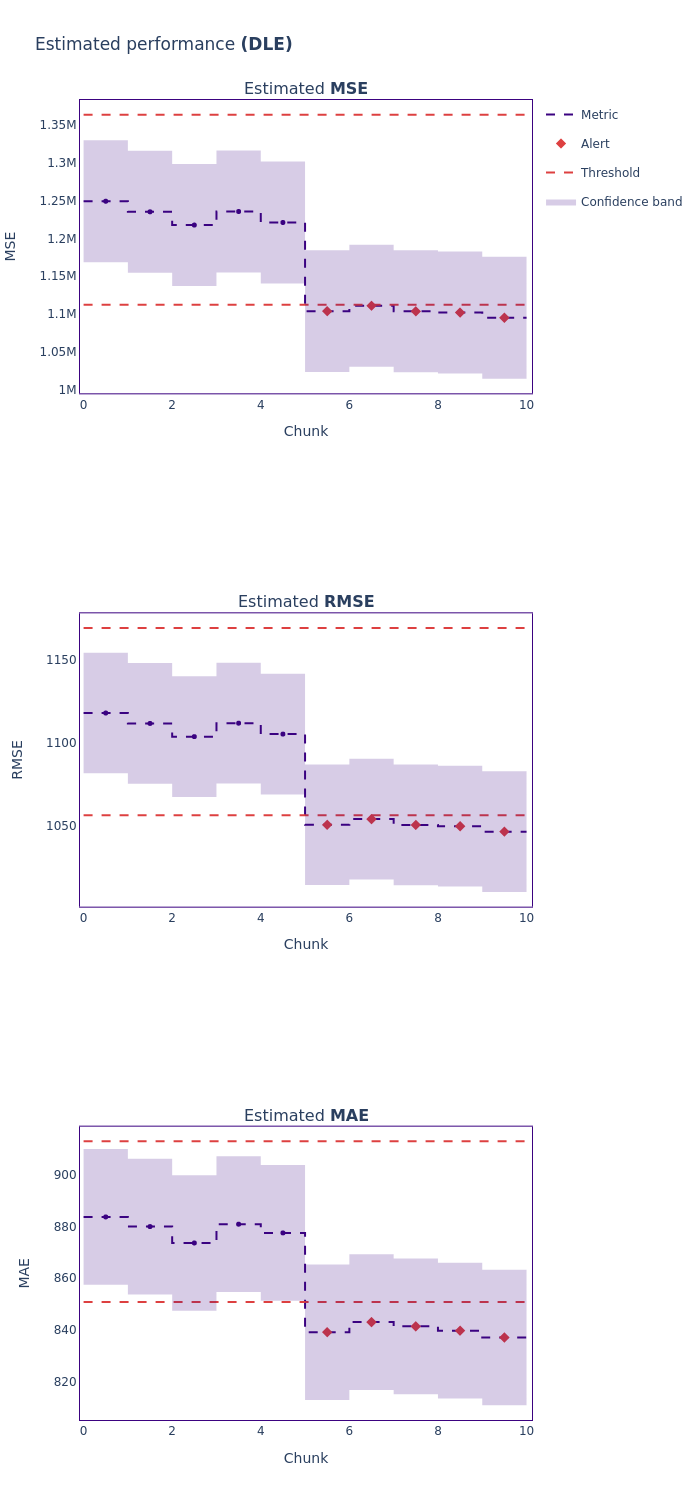

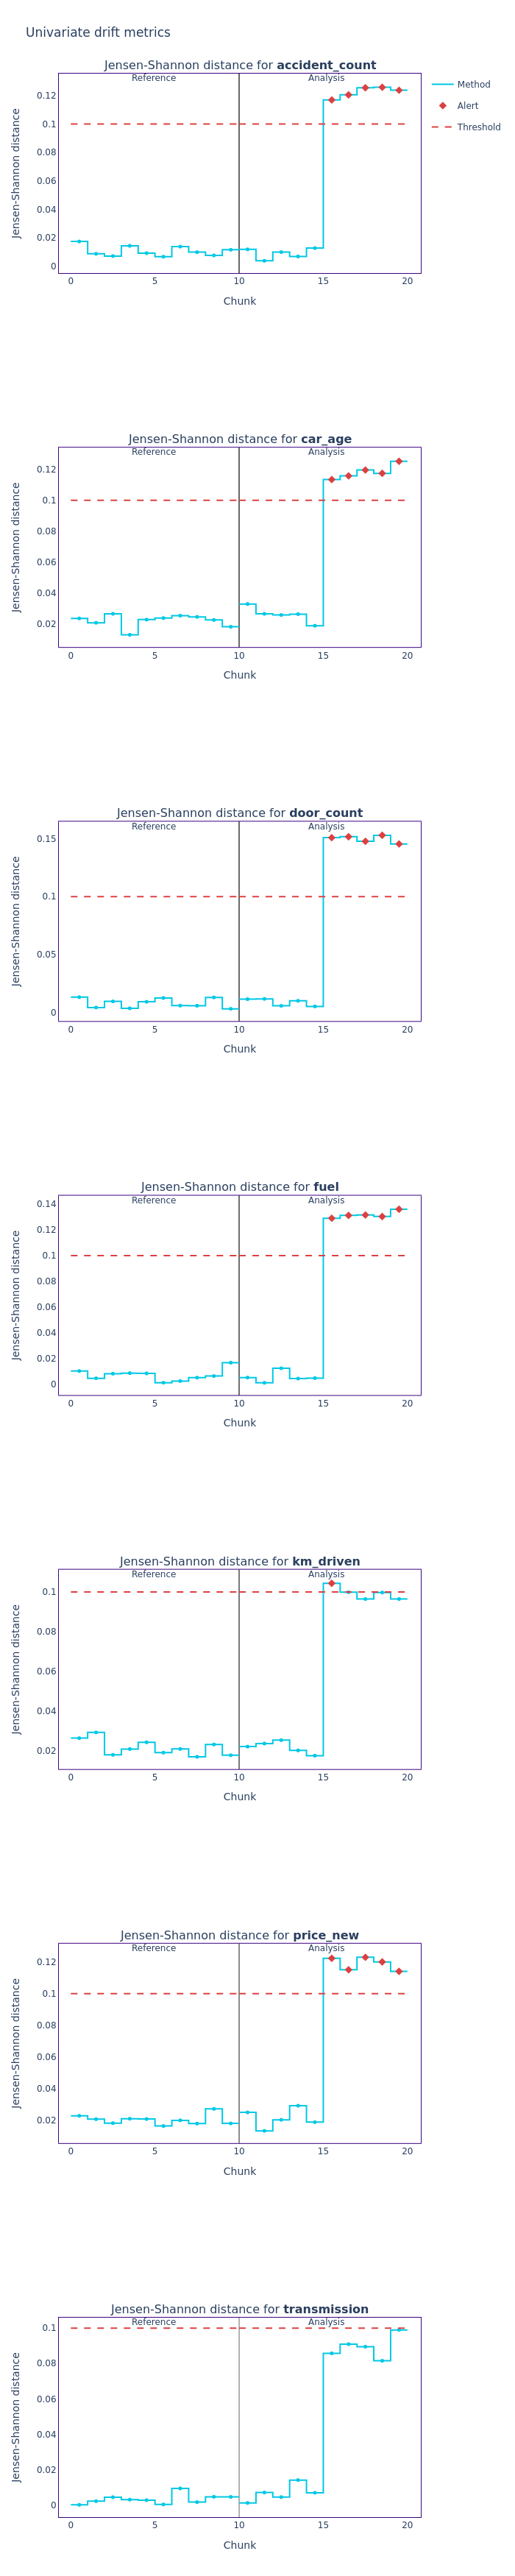

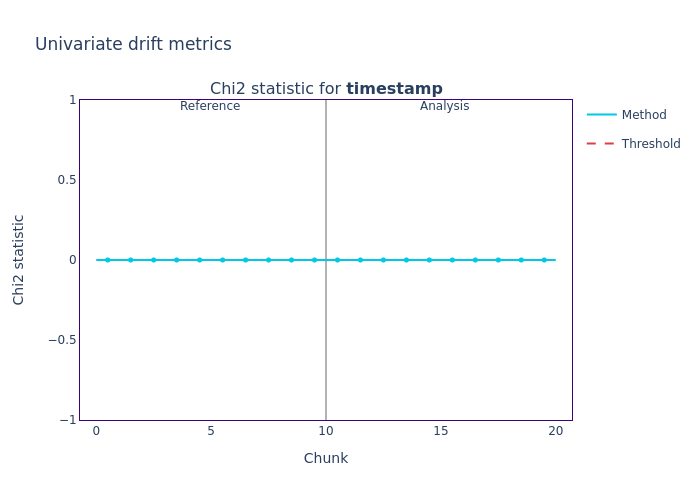

In [19]:
from PIL import Image
# Read image
img1 = Image.open('./output/performance_monitoring.png')
img2 = Image.open('./output/drift_continuous.png')
img3 = Image.open('./output/drift_categorical.png')
# Output Images
img1.show()
img2.show()
img3.show()

#### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [23]:
predictor=sage.predictor.Predictor(model_name, sagemaker_session,content_type)
predictor.delete_endpoint(delete_endpoint_config=True)

### 4. Clean-up

#### A. Delete the model

In [24]:
model.delete_model()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

